In [ ]:
import gc

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

import eli5
from eli5.sklearn import PermutationImportance

%matplotlib inline

In [305]:
train = pd.read_hdf('../input/train_online_retail.h5')
test = pd.read_hdf('../input/test_online_retail.h5')
df_all = pd.concat([train, test], sort=False)
del train, test
gc.collect()

df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 12 to 541893
Data columns (total 11 columns):
invoice         1067371 non-null int32
stock_code      1067371 non-null int16
description     1062989 non-null object
quantity        1067371 non-null int32
invoice_date    1067371 non-null datetime64[ns]
price_unit      1067371 non-null float16
price_total     1067371 non-null float32
customer_id     1067371 non-null int16
country         1067371 non-null object
is_canceled     520142 non-null object
is_test         1067371 non-null bool
dtypes: bool(1), datetime64[ns](1), float16(1), float32(1), int16(2), int32(2), object(3)
memory usage: 60.1+ MB


In [ ]:
df_all['is_canceled'].count_

In [263]:
df_all[ ~df_all['is_test'] ].groupby('customer_id')['is_canceled'].agg(np.sum)

customer_id
-1       305.0
 0         8.0
 1        30.0
 2         0.0
 3         3.0
         ...  
 5930      0.0
 5935      0.0
 5936      0.0
 5938      0.0
 5940      0.0
Name: is_canceled, Length: 4880, dtype: float64

In [383]:
df_all[ ~df_all['is_test'] ].groupby('customer_id')['is_canceled'].agg(np.sum)

customer_id
-1       305
 0         8
 1        30
 2         0
 3         3
        ... 
 5930      0
 5935      0
 5936      0
 5938      0
 5940      0
Name: is_canceled, Length: 4880, dtype: object

In [389]:
def group_to_dict(group_key, agg_func):
    train = df_all[ ~df_all['is_canceled'].isnull()]
    dict_ = train.groupby(group_key)['is_canceled'].agg(agg_func).to_dict()
    if -1 in dict_: del dict_[-1]
    
    val = [x for x in dict_.values()]
    dict_['mean'] = np.mean(val)
    print(dict_['mean'])
    return dict_

In [390]:
# customer feats dicts
cnt_customer_orders_dict = group_to_dict('customer_id', np.size)
cnt_customer_cancel_dic = group_to_dict('customer_id', np.sum)

# product feats dicts
cnt_product_orders_dict = group_to_dict('stock_code', np.size)
cnt_product_cancel_dic = group_to_dict('stock_code', np.sum)

83.69419963107194
1.980323836851814
103.08006341656758
1.9752279032897344


In [382]:
# customer feats
df_all['cnt_customer_orders'] = df_all['customer_id'].map(lambda x: int(cnt_customer_orders_dict.get(x, cnt_customer_orders_dict['mean'])))
df_all['cnt_customer_cancel'] = df_all['customer_id'].map(lambda x: int(cnt_customer_cancel_dic.get(x, cnt_customer_cancel_dic['mean'])))
df_all['prc_customer_cancel'] = df_all[['cnt_customer_orders', 'cnt_customer_cancel']].apply(lambda x: x['cnt_customer_cancel'] / x['cnt_customer_orders'] if x['cnt_customer_orders'] != 0 else 0, axis=1)

# produkt feats
df_all['cnt_product_orders'] = df_all['stock_code'].map(lambda x: int(cnt_product_orders_dict.get(x, cnt_product_orders_dict['mean'])))
df_all['cnt_product_cancel'] = df_all['stock_code'].map(lambda x: int(cnt_product_cancel_dic.get(x, cnt_product_cancel_dic['mean'])))
df_all['prc_product_cancel'] = df_all[['cnt_product_orders', 'cnt_product_cancel']].apply(lambda x: x['cnt_product_cancel'] / x['cnt_product_orders'] if x['cnt_product_orders'] != 0 else 0, axis=1)

# date feats

In [322]:
# tested feats


In [406]:
df_all[ df_all['customer_id'] == -1 ].sample(5)

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test,cnt_customer_orders,cnt_customer_cancel,prc_customer_cancel,cnt_product_orders,cnt_product_cancel,prc_product_cancel
36954,1756,6,SAVE THE PLANET MUG,2,2009-12-16 17:58:00,3.429688,6.86,-1,United Kingdom,False,False,83,1,0.012048,411,18,0.043796
52120,2691,637,RED LOVE HEART SHAPE CUP,1,2010-01-11 14:39:00,1.660156,1.66,-1,United Kingdom,NaN,True,83,1,0.012048,173,0,0.000000
343606,45261,4165,CARD CIRCUS PARADE,1,2011-09-15 16:37:00,0.830078,0.83,-1,United Kingdom,NaN,True,83,1,0.012048,226,1,0.004425
440440,24952,3937,WOODEN SCHOOL COLOURING SET,2,2010-11-08 09:20:00,3.359375,6.72,-1,United Kingdom,NaN,True,83,1,0.012048,473,7,0.014799
361512,20801,324,NO SINGING METAL SIGN,1,2010-09-28 17:18:00,4.210938,4.21,-1,United Kingdom,False,False,83,1,0.012048,641,5,0.007800


In [209]:
def group_orders(df):
    orders = df.groupby('invoice')['is_canceled', 'price_total'].sum()
    orders['is_canceled'] = orders['is_canceled'].map(lambda x: True if x>0 else False)
    orders['price_canceled'] = orders['is_canceled'] * orders['price_total']
    return orders

In [172]:
def get_feats_X_y(df):
    
    # select feats
    black_list = ['is_canceled', 'is_test']
    feats = df.select_dtypes([np.bool, np.number]).columns
    feats = [x for x in feats if x not in black_list]
                  
    X = df[feats]
    y = df['is_canceled']
    
    return X, y, feats

In [391]:
# prepare to train
train = df_all[ ~df_all['is_test'] ].copy()
test = df_all[ df_all['is_test'] ].copy()

#release memory
del df_all
gc.collect()

In [392]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520142 entries, 12 to 541909
Data columns (total 17 columns):
invoice                520142 non-null int32
stock_code             520142 non-null int16
description            517903 non-null object
quantity               520142 non-null int32
invoice_date           520142 non-null datetime64[ns]
price_unit             520142 non-null float16
price_total            520142 non-null float32
customer_id            520142 non-null int16
country                520142 non-null object
is_canceled            520142 non-null object
is_test                520142 non-null bool
cnt_customer_orders    520142 non-null int64
cnt_customer_cancel    520142 non-null int64
prc_customer_cancel    520142 non-null float64
cnt_product_orders     520142 non-null int64
cnt_product_cancel     520142 non-null int64
prc_product_cancel     520142 non-null float64
dtypes: bool(1), datetime64[ns](1), float16(1), float32(1), float64(2), int16(2), int32(2), int64(4), ob

In [393]:
train.is_canceled.value_counts()

False    510175
True       9967
Name: is_canceled, dtype: int64

In [394]:
train['is_canceled'] = train['is_canceled'].astype(bool)
train.is_canceled.value_counts()

False    510175
True       9967
Name: is_canceled, dtype: int64

In [227]:
orders = group_orders(train)

X = orders[ [ 'is_canceled' ] ]
y = orders[ 'price_canceled' ]

model = DummyRegressor(strategy='mean')
model.fit(X, y)
y_pred = model.predict(X)

score = mean_squared_error(y, y_pred)
score

1492585.5

In [7]:
train['is_canceled'].value_counts(normalize=True)

False    0.980838
True     0.019162
Name: is_canceled, dtype: float64

In [329]:
orders['is_canceled'].value_counts(normalize=True)

False    0.845379
True     0.154621
Name: is_canceled, dtype: float64

In [395]:
X, y, feats = get_feats_X_y(train)
feats

['invoice',
 'stock_code',
 'quantity',
 'price_unit',
 'price_total',
 'customer_id',
 'cnt_customer_orders',
 'cnt_customer_cancel',
 'prc_customer_cancel',
 'cnt_product_orders',
 'cnt_product_cancel',
 'prc_product_cancel']

In [ ]:
def test_model(model, scoring='recall', check_distribution=False):
    cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    print('scores: {}'.format(scores))
    print('mean: {}, std: {} \n'.format(np.mean(scores), np.std(scores)))
    
    if check_distribution:
        y_pred = pd.Series(cross_val_predict(model, X, y, cv=cv))
        print('y_pred value_counts: \n{}'.format(y_pred.value_counts(normalize=True)))

In [404]:
def plot_model_char(model, check_confusion=True, check_feature_importance=True, check_learning_curve=True):
    
    if check_confusion:
        cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
        y_pred = cross_val_predict(model, X, y, cv=cv)
        skplt.metrics.plot_confusion_matrix(y, y_pred, normalize=True, figsize=(10 ,10))
    
    if check_feature_importance or check_learning_curve:
        model.fit(X, y)
    
    if check_feature_importance:
        skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))
    
    if check_learning_curve:
        skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='recall');

In [396]:
model = DecisionTreeClassifier(max_depth=10, random_state=0)
test_model(model)

scores: [0.3641288  0.35159542 0.37116195]
mean: 0.36229539145100564, std: 0.008092518148307526 



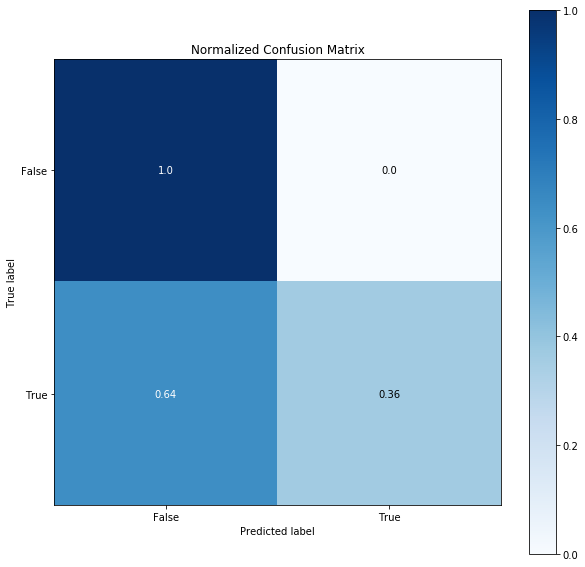

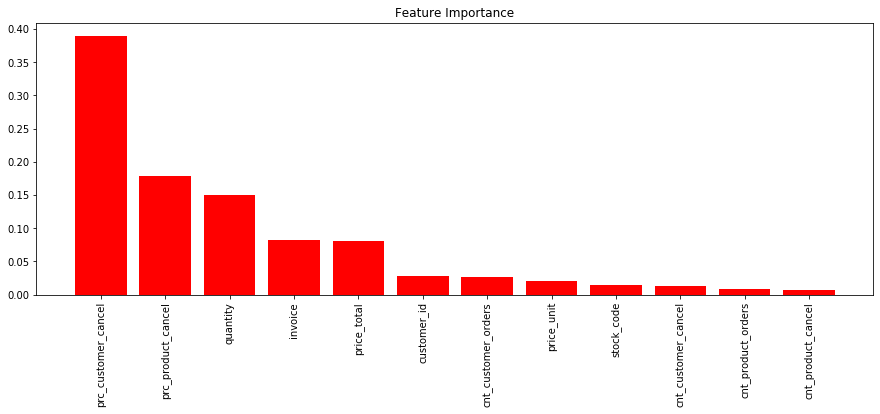

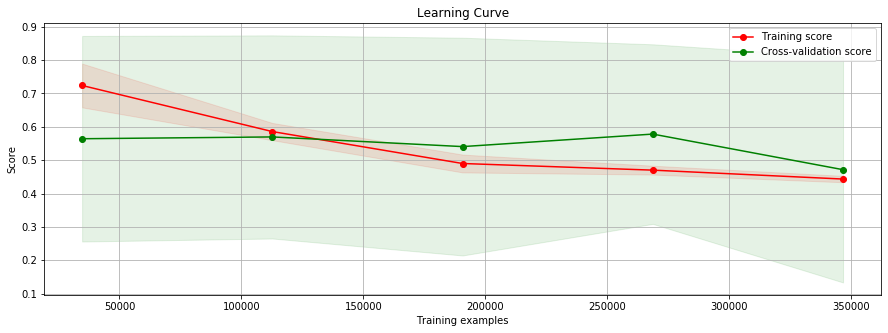

In [341]:
plot_model_char(model)

In [409]:
xgb_params = {
    'max_depth' : 30,
    'n_estimators' : 100,
    'learning_rate': 0.3,
    'seed': 0
}

In [398]:
model = XGBClassifier(**xgb_params)
test_model(model)

scores: [0.43906109 0.44220349 0.4449127 ]
mean: 0.4420590948134279, std: 0.0023910923500048767 



In [ ]:
plot_model_char(model, False, False, True)

In [ ]:
# m = XGBClassifier(**xgb_params)
# m.fit(X,y)

# imp = PermutationImportance(m, random_state=0).fit(X,y)
# eli5.show_weights(imp, feature_names=feats)

In [408]:
#train and predict

model = XGBClassifier(**xgb_params)
model.fit(train[feats], train['is_canceled'])
test['is_canceled'] = model.predict(test[feats])

test_model(model, scoring='neg_mean_absolute_error', check_distribution=False)

scores: [0.53686428 0.54304636 0.53762793]
mean: 0.5391795239535154, std: 0.0027519804313083326 

y_pred value_counts: 
False    0.987603
True     0.012397
dtype: float64


In [ ]:
#prepare submit
test['total_return'] = test['price_total'] * test['is_canceled']
result = test.groupby('invoice')['total_return'].agg(np.sum).to_frame().reset_index()

result[ ['invoice', 'total_return'] ].to_csv('../output/xgb_and_cnt_features.csv', index=False)